# Distributed Representation for language modelling

- Seems to be quite similar to how modern LLMs work but with an MLP instead of Transformer. 
\
The only difference is that modern LLMs use more modern techniques (Transformers, AdamW optimizer, adaptive learning rate, way more parameters, post-training, etc...) 
\
Same fundemantel ideas. Different architecture and scale.
- Words, Letters, or more generally tokens are represented as feature vectors. 
- Embedding of words is trained by backprop: \
Words -> Embedding -> Predict next token (using a n-gram context window)
- We train using a dataset of n-gram "sentences". 

#### General setup:
- **Embedding layer**: \
Map vocab token to an embedding via a lookup table (i.e. a matrix multiplication on one-hot encoded input token). Do this for each token in the context window.

- **MLP layer + nonlinearity**: \
Pass input to MLP and output logits for predicting the next token. The input size is the size of our context window and embedding dimensionality, outputs some feature vector of custom dimensionality.

- **Mapping feature to logits**: \
We then map the feature vector (hidden layer vector) h to a "score" over the vocab:\
$logit = b + Wh + Ux \in \mathbb{R}^{|V|}$\
where $Wh$ is the mapping from feature to vocab. and $Ux$ represents a "skip layer" of some sorts coming all the way from the input

- **Softmax**: \
Compute the softmax over logits to obtain probabilities



#### Setup:

1. Onehot encode N inputs (context window size) into a matrix of (N, 27)
2. "extract" embedding from lookup table using onehot-encoding vector via a matrix multiplication \
Since onehot @ emebdding matrix = extraction of a specific row (which represents the embedding) \
Onehot (N, 27) @ Embedding (27, $D_{emb}$) = Embedding matrix (N, $D_{emb}$)
3. 

In [137]:
import torch as th
from torch.utils.data import Dataset, DataLoader
from torch import optim
import torch.nn.functional as F

In [138]:
# Prepare dataset of samples with (N-1) context 
words = open('./datasets/names.txt', 'r').read().splitlines()
print(min(len(w) for w in words))  # shortest name length
print(max(len(w) for w in words))  # longest name length

# NOTE: Need to handle edge cases where names are shorter than context length

# Compute the statistics of the whole dataset in a dictionary
counts = {}
for w in words:
    chs = ['.'] + list(w) + ['.']      
    for a, b in zip(chs, chs[1:]):             # iterate over all bigram pairs
        if a not in counts:
            counts[a] = {}                     # create a new entry if a hasn't been seen before

        if b not in counts[a]:                 # create a new entry if b_ hasn't been seen before
            counts[a][b] = 0
        counts[a][b] += 1                      # increment count for the pairs we encounter

# Create character-level vocabulary
charset = sorted(list(counts.keys()))               # get all the unique characters  
stoi = {s: i for i, s in enumerate(charset)}        # string to index
itos = {i: s for s, i in stoi.items()}              # index to string

2
15


In [139]:
CONTEXT_WINDOW = 3
VOCAB_SIZE = 27         # 26 letters + 1 for special 'end of name' character

# Convert dataset into input/output samples for training
X, Y = [], []
for w in words:
    context = [0] * CONTEXT_WINDOW          # initialize context with all '.'
    for ch in w + '.':                      # for each character in the name + end character
        ix = stoi[ch]                       # get the index of the character
        X.append(context)                   # add the current context to inputs
        Y.append(ix)                        # add the current character index to outputs
        context = context[1:] + [ix]        # update context by appending the current character and removing the starting char

X = th.tensor(X)
Y = th.tensor(Y)

print(X.shape)

torch.Size([228146, 3])


In [140]:
# Scratchpad/experimenting area
E = th.randn(27, 2)
print(E.shape)
print(X.shape)
print(X)

# what happens is that X contains the indices into E has values. Only contains values from 0 to 27
# When we do E[X], it retrieves the rows of E corresponding to the indices in X which has 2 elements
# Since there are 3 elements per row in X, we get [32, 3, 2] = [nr_data, context_window, emb_dim]. 
# In other words, for each of the 32 samples, we have 3 context characters, each represented by a 2-dimensional embedding vector.
# Indexing using tensors or lists returns a new tensor, hence why this is possible
print(E[X].shape)   
print(X[0, 0])
print(E[0, 0])

# E = Embedding Matrix (|V|, emb_dim)
# X = input data (nr_data, context_window)

# one_hot = F.one_hot(X[:5], num_classes=VOCAB_SIZE).float()   # shape: (nr_data, context_window, vocab_size)
# print(one_hot.shape)
# manual_emb = one_hot @ E                                     # shape: (nr_data, context_window, emb_dim)
# print(manual_emb.shape)

# emb = E[X[:5]]                                               # shape: (nr_data, context_window, emb_dim)
# print(E[X[:5]].shape)

# print(manual_emb == emb)

torch.Size([27, 2])
torch.Size([228146, 3])
tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        ...,
        [26, 26, 25],
        [26, 25, 26],
        [25, 26, 24]])
torch.Size([228146, 3, 2])
tensor(0)
tensor(-0.2465)


In [141]:
# Construct the dataset 
class NameDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


# Train split
train_end = int(0.8 * len(X))
train_dataloader = DataLoader(NameDataset(X[:train_end], Y[:train_end]), batch_size=32, shuffle=True)

# Dev split
dev_end = int(0.9 * len(X))
dev_dataloader = DataLoader(NameDataset(X[train_end:dev_end], Y[train_end:dev_end]), batch_size=32)

# Test split
test_dataloader = DataLoader(NameDataset(X[dev_end:], Y[dev_end:]), batch_size=32)

# Manual Tensor NN
First model uses only tensors and little pytorch ready functionality.

Model parameter dimensions: 
1. $ y = b + U tanh(d + Hx) $ 
2. $ y \in \mathbb{R}^{|V|} $ 
3. $ b \in \mathbb{R}^{|V|}$ 
4. $ U \in \mathbb{R}^{|V| , h}$ 
5. $ d \in \mathbb{R}^{h}$ 
6. $ H \in \mathbb{R}^{h , (n-1) m}$ 
7. $ x \in \mathbb{R}^{(n-1)m}$ 


#### How to determine a good learning rate?
1. Find a good learning rate from a range of learning rates. An interval of exponentially increasing learning rates.
2. Schedule learning rate to decay after loss somewhat plateaus.
3. Use more modern optimization algorithms

#### Testing/validating model
Split data into 80-10-10 train-dev/validation-test splits. dev/validation split is the data used to search through hyperparameters. So we train several model on 80% of the data with different hyperparameters. Then we validate it on the dev split to see which hyperparameters turned out to be most optimal.

Finally we test on the test split to see how our model has generalized. We can't do this too often as it risks overfitting on the test split. Not sure yet what to do if test split results are very poor (restart again? change parameters? ...)

#### Exercises:
1. Implement a search for "optimal" learning rate and an adaptive learning rate scheduler?
2. Implement a few different optimization algorithms (Momentum, RMSprop, Adam, Adagrad)
3. Test out different hyperparameters (hidden size, embedding size) using the validation-test split


In [98]:
# Model hyperparameters
emb_dim = 2
hid_dim = 100
EPOCHS = 10
LEARNING_RATE = 0.1

# Model parameters
E = th.randn(VOCAB_SIZE, emb_dim, requires_grad=True)                    # embedding matrix

W1 = th.randn((CONTEXT_WINDOW * emb_dim, hid_dim), requires_grad=True)   # first layer weights
b1 = th.randn(hid_dim, requires_grad=True)                               # first layer bias

W2 = th.randn((hid_dim, VOCAB_SIZE), requires_grad=True)                 # second layer weights
b2 = th.randn(VOCAB_SIZE, requires_grad=True)                            # second layer bias

In [ ]:
# Training loop
for epoch in range(EPOCHS):
    for batch_X, batch_Y in train_dataloader:
        # Forward pass
        # We start with extracting the embedding for the batch
        # emb = E[batch_X]                                        # shape: (batch_size, context_window, emb_dim)

        # OPTIONAL: Use onehot encoding multiplication to index into embeddings
        onehot = F.one_hot(batch_X, num_classes=VOCAB_SIZE).float()   # shape: (batch_size, context_window, vocab_size)
        emb = onehot @ E                                              # shape: (batch_size, context_window,

        # MLP forward pass
        h = (emb.view(-1, CONTEXT_WINDOW * emb_dim) @ W1) + b1  # shape: (batch_size, hid_dim)
        h_tanh = th.tanh(h)                                     # apply non-linearity
        logits = (h_tanh @ W2) + b2                             # shape: (batch_size, VOCAB_SIZE)
        
        # Compute CE loss (manually) 
        # counts = logits.exp()
        # Sum over first dimension because of batching. We have (batch_size, VOCAB_SIZE) where each row corresponds to
        # the probabilities of a sample (up to batch size) over the entire vocabulary. This corresponds to dim=1 and we 
        # thus sum over dim=1. We keepdim=True because we want to maintain the (batch, VOCAB_SIZE) shape.
        # probs = counts / counts.sum(1, keepdim=True)            # shape: (batch_size, VOCAB_SIZE)
        # Extract the probabilities. Note that we have a batch of data, so we need to index accordingly
        # For each sample in the batch, we want the probability of the true class (batch_Y). 
        # So from every row (corresponds to batch, which corresponds to the indices generated by th.arane(...)
        # we extract its corresponding true class probability (indexed by batch_Y)
        # loss = -probs[th.arange(batch_Y.shape[0]), batch_Y].log().mean()

        # Alternatively we can use:
        loss = F.cross_entropy(logits, batch_Y)

        # Zero gradients from previous step
        for param in [E, W1, b1, W2, b2]:
            param.grad = None

        # Backward pass
        loss.backward()

        # Update parameters
        with th.no_grad():
            for param in [E, W1, b1, W2, b2]:
                param += - LEARNING_RATE * param.grad


    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

Epoch 1, Loss: 2.277381658554077
Epoch 2, Loss: 2.552737236022949
Epoch 3, Loss: 2.0968680381774902
Epoch 4, Loss: 2.0689585208892822
Epoch 5, Loss: 2.4757509231567383
Epoch 6, Loss: 2.28945255279541
Epoch 7, Loss: 2.310854911804199
Epoch 8, Loss: 2.239020824432373
Epoch 9, Loss: 3.0879671573638916
Epoch 10, Loss: 2.375091552734375


In [109]:
# Inference
context = [0] * CONTEXT_WINDOW    # initialize context with all '.'
out_name = ''

# E         := (|V|, emb_dim)
# context   := (context_window,)
while True:
    ## Sample the next character
    # First obtain embedding
    # emb = E[th.tensor([context])]                                             # shape: (1, context_window, emb_dim)
    onehot = F.one_hot(th.tensor([context]), num_classes=VOCAB_SIZE).float()    # shape: (1, context_window, emb_dim)
    emb = onehot @ E

    # Forward pass
    h = (emb.view(-1, CONTEXT_WINDOW * emb_dim) @ W1) + b1  
    h_tanh = th.tanh(h)                                     
    logits = (h_tanh @ W2) + b2                             

    # Sample from the distribution
    counts = logits.exp() 
    probs = counts / counts.sum(1, keepdim=True)            # shape: (1, VOCAB_SIZE)
    ix = th.multinomial(probs, num_samples=1).item()        # sample index
    ch = itos[ix]                                           # get character from index

    ## Add character to name
    ch = itos[ix]  

    # Stop if we reach end of name character
    if ch == '.':
        break
    
    out_name += ch

    ## Update context window
    # Update context by appending the current character and removing the starting char. This keeps the context array size fixed
    context = context[1:] + [ix]       

print(out_name)

dazeiah


# NN Using pytorch shortcuts

Same model, same thing but now using all the pytorch functionality

In [158]:
# V:    vocab size
# m:    embedding size 
# h:    hidden size of hidden layer
# n-1:  context window size

class MLP(th.nn.Module):
    def __init__(self, emb_dim, h):
        super(MLP, self).__init__()

        self.emb_dim = emb_dim 
        self.h = h 
        
        self.embedding = th.nn.Embedding(VOCAB_SIZE, emb_dim)       # embedding layer
        self.fc1 = th.nn.Linear(CONTEXT_WINDOW * emb_dim, h)        # first fully connected layer
        self.fc2 = th.nn.Linear(h, VOCAB_SIZE)                      # output layer

    def forward(self, x):
        """ 
        x:  (batch_size, n-1) tensor of input indices
            n-1 because we concatenated n-1 inputs together to form the context

        returns: (batch_size, V) tensor of output logits
        """
        x = self.embedding(x)                       # Returns (batch_size, context_window, emb_dim)
        x = x.view(-1, CONTEXT_WINDOW * self.emb_dim)    # Returns (batch_size, context_window * emb_dim)
        x = th.tanh(self.fc1(x))                    # Returns (batch_size, hid_dim)
        x = self.fc2(x)                             # Returns (batch_size, V)
        return x

In [162]:
# Training loop
EPOCHS = 20
LEARNING_RATE = 0.01

model = MLP(emb_dim=10, h=200)  # n = context window + 1
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

# print nr. of params
print(sum(p.numel() for p in model.parameters()))

steps, losses = [], []
# Train on train dataset
for epoch in range(EPOCHS):  # number of epochs
    epoch_loss = 0
    for batch_X, batch_Y in train_dataloader:
        optimizer.zero_grad()                       # zero the gradients

        # batch_X: (batch_size, context_window), contains the indices to extract
        logits = model(batch_X)                     # forward pass
        loss = F.cross_entropy(logits, batch_Y)     # compute loss
        loss.backward()                             # backward pass
        optimizer.step()                            # update parameters

        epoch_loss += loss.item()

    # Store and print stats
    steps.append(epoch)
    losses.append(epoch_loss / len(train_dataloader))
    print(f"Epoch {epoch+1}, Training Loss: {epoch_loss / len(train_dataloader)}")

11897
Epoch 1, Training Loss: 2.525839652014481
Epoch 2, Training Loss: 2.377052959310724
Epoch 3, Training Loss: 2.3201525572264177
Epoch 4, Training Loss: 2.27967819517157
Epoch 5, Training Loss: 2.2507068766241822
Epoch 6, Training Loss: 2.2289081892993976
Epoch 7, Training Loss: 2.211314871280257
Epoch 8, Training Loss: 2.1965147044514874
Epoch 9, Training Loss: 2.1842573696608967
Epoch 10, Training Loss: 2.1734250657897847
Epoch 11, Training Loss: 2.1638857355709664
Epoch 12, Training Loss: 2.155269645896399
Epoch 13, Training Loss: 2.147939968744468
Epoch 14, Training Loss: 2.1403270829233847
Epoch 15, Training Loss: 2.1339529671642254
Epoch 16, Training Loss: 2.1279579317210264
Epoch 17, Training Loss: 2.1226331071841935
Epoch 18, Training Loss: 2.1173867183263306
Epoch 19, Training Loss: 2.1125379034003235
Epoch 20, Training Loss: 2.1081769354171205


#### Training and evaluating in practice
How do we choose which model, hyperparameters, etc.. to use in practice?
- Run models for various (sensible) choices of hyperparameters
- Evaluate these models on the validation/dev split and choose the one that optimizes it
- Pick out that model that optimizes dev split and evaluate it on test split **ONCE**
- This evaluation is what we report

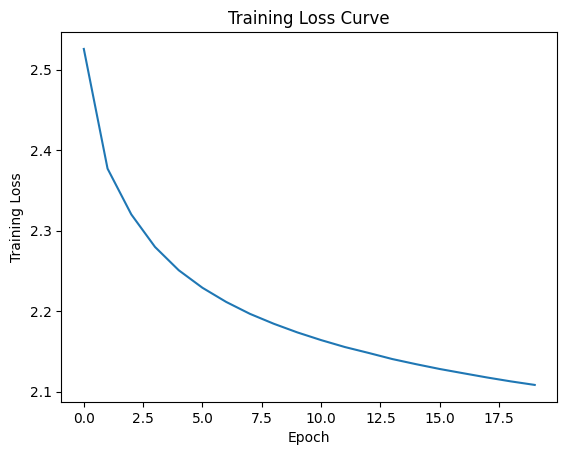

In [163]:
# Plot training loss curve
import matplotlib.pyplot as plt 

plt.plot(steps, losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Curve')
plt.show()

In [164]:
# Evaluate on test data
with th.no_grad():
    total_loss = 0
    for batch_X, batch_Y in test_dataloader:
        logits = model(batch_X)
        loss = F.cross_entropy(logits, batch_Y)
        total_loss += loss.item()
    
    avg_loss = total_loss / len(test_dataloader)
    print(f"Test Loss: {avg_loss}")

# Dev loss 
with th.no_grad():
    total_loss = 0
    for batch_X, batch_Y in dev_dataloader:
        logits = model(batch_X)
        loss = F.cross_entropy(logits, batch_Y)
        total_loss += loss.item()
    
    avg_loss = total_loss / len(dev_dataloader)
    print(f"Dev Loss: {avg_loss}")

# If these losses seem similar then we are not overfitting. If we overfit then these losses would be much higher than the 
# training loss. This implies we could potentially increase the model capacity or train for longer without overfitting.

Test Loss: 2.3970410696754616
Dev Loss: 2.3715264748724447


In [177]:
# Inference
# Generate new name by starting with context of all '.' and procedurally sampling the next character 
context = [0] * CONTEXT_WINDOW    # initialize context with all '.'
out_name = ''

while True:
    # Sample the next character
    out = model(th.tensor([context]))
    probs = F.softmax(out, dim=1)  # get probabilities
    ix = th.multinomial(probs, num_samples=1).item()  # sample index
    ch = itos[ix]                                     # get character from index
    
    if ch == '.':
        break
    out_name += ch

    # Update context window
    context = context[1:] + [ix]   
    
print(out_name)

kille
